In [1]:
import os, pickle
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
# matplotlib.use('agg')
import matplotlib.pyplot as plt
import multiprocessing as mp

from glob import glob
from functools import partial

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler

import warnings
warnings.filterwarnings('ignore')

In [50]:
##################
train_name = 'all'
site_list_fix = ['CLN', 'ALTA', 'AGD', 'BCC', 'SLB', 'PVC', 'CSSL', 'BSNFJE', 'BSNFEX', 'BSFDC',]
include_keys = ['T', 'SPD', 'R']#U', 'V']

use_intervals = [12, 24]
use_var_type = ['mean']#, 'max', 'min']

min_slr, max_slr = 0, 40
max_T_650 = 2 + 273.15
min_swe_mm = 2.54 * 1

use_scaler = RobustScaler(quantile_range=(25, 75))  #StandardScaler() #
train_size, test_size, random_state = None, 0.33, 5

svr_tune_on = 'mse'#['mse', 'mae', 'mare', 'r2']
crange = np.arange(5, 121, 5)
erange = np.arange(0, 5.1, .25)

mp_cores = 86
mp_method = 'fork'
##################

In [51]:
##################
def MARE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

def SVR_mp(_params, train_predictors, train_target):
    
    print('.', end='')
    
    _i, _j, _C, _e = _params
    
    _model = SVR(
                C=_C, #Ridge regularization parameter for (L2)^2 penalty
                epsilon=_e, #Specifies the epsilon-tube within which no penalty is associated in the training loss function
                kernel='rbf', #'linear', 'polynomial', 'rbf'
                degree=3, #pass interger for 'polynomial' kernel, ignored otherwise
                tol=0.001, #stopping tolerance
                shrinking=False, 
                cache_size=200, 
                verbose=False)
    
    _model.fit(train_predictors, train_target)
    
    test_predictions = _model.predict(X_test_norm).flatten()
    _r2 = _model.score(X_test_norm, y_test) #sklearn.metrics.r2_score(y_test.values.flatten(), test_predictions)
    _mse = sklearn.metrics.mean_squared_error(y_test.values.flatten(), test_predictions)
    _mae = sklearn.metrics.mean_absolute_error(y_test.values.flatten(), test_predictions)
    _mare = MARE(y_test.values.flatten(), test_predictions)
    
    return (_i, _j, _C, _e, _r2, _mae, _mse, _mare, _model)


##################

In [52]:
obdir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/'
figdir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/output/slr_figures/'
outdir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/output/slr_models/'

flist = glob(obdir + 'combined/*.pd')

# This can be a manual site list if desired
site_list = np.unique([f.split('/')[-1].split('_')[0] for f in flist])

#site_list = [s for s in site_list if 'BSNF' not in s]
site_list = site_list_fix if site_list_fix is not None else site_list

print('Training on:\n%s\n'%'\n'.join(site_list))

# favor = 'long' #'long'

flist = []
for site in site_list:

    # Trim here if only using 12/24 UTC
    for interval in use_intervals:        
        flist.append(glob(obdir + 'combined/%s*%d*.pd'%(site, interval)))

flist = np.hstack(flist)
flist = [f for f in flist if '.isobaric.' in f]
print('Source files:\n%s\n'%'\n'.join(flist))

Training on:
CLN
ALTA
AGD
BCC
SLB
PVC
CSSL
BSNFJE
BSNFEX
BSFDC

Source files:
/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/CLNX_1999_2019.12h.isobaric.pd
/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/CLNX_1999_2019.24h.isobaric.pd
/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/ALTA_1980_2020.24h.isobaric.pd
/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/AGD_2004_2019.12h.isobaric.pd
/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/AGD_2004_2019.24h.isobaric.pd
/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/BCC_2004_2019.12h.isobaric.pd
/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/BCC_2004_2019.24h.isobaric.pd
/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/SLB_1980_2020.24h.isobaric.pd
/uufs/chpc.utah

In [74]:
data = []
for f in flist:

    site = f.split('/')[-1].split('_')[0]

    df = pd.read_pickle(f)

    keys = ['slr', 'swe_mm']
    keys.extend(np.hstack([[k for k in df.keys()
                            if ((vt in k) & (k.split('_')[0] in include_keys))] 
                           for vt in use_var_type]))

    df = df.loc[:, keys].rename(columns={[k for k in keys if 'swe' in k][0]:'swe_mm'})
    df = df.loc[:, :].rename(columns={[k for k in keys if 'swe' in k][0]:'swe_mm'})
    df = df.rename(columns={[k for k in keys if 'slr' in k][0]:'slr'})
    df = df.drop(columns=[k for k in keys if 'auto' in k])

    # df.insert(0, 'site', np.full(df.index.size, fill_value=site, dtype='U10'))
    doy = [int(pd.to_datetime(d).strftime('%j')) for d in df.index]
    #df.insert(2, 'day_of_year', doy)

    data.append(df.reset_index().drop(columns='time'))

data = pd.concat(data, sort=False)

# Treat the mean value as the instantaneous value for later applications,
# we can change this behavior later on if desired. 
# An alternate method would be to keep the 'mean' tag through training 
# and choose behavior upon application
data = data.rename(columns={k:k.replace('_mean', '') for k in data.keys()})

data = data[data['slr'] >= min_slr]
data = data[data['slr'] <= max_slr]
data = data[data['T_650'] <= max_T_650]
data = data[(data['swe_mm'] >= min_swe_mm)&(data['swe_mm'] <= 150)]

# data['slr'] = np.log(data['slr'])

# data.pop('swe_mm')

data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()

slr = data['slr']

print('\nTotal: %d'%len(data))

level_keys = [k.split('_') for k in data.keys()]

keep_keys = []
for level_key in level_keys:
    try:
        level = int(level_key[-1])
    except:
        keep_keys.append('_'.join(level_key))
    else:
        if ((level <= 750) & (level >= 400)):
            keep_keys.append('_'.join(level_key))
            
data = data[keep_keys]
data

data


Total: 11545


,slr,swe_mm,T_400,R_400,SPD_400,T_450,R_450,SPD_450,T_500,R_500,...,SPD_600,T_650,R_650,SPD_650,T_700,R_700,SPD_700,T_750,R_750,SPD_750
0,9.520000,10.67,246.963516,88.793442,23.306822,252.893295,93.976524,22.355556,258.263855,89.814735,...,18.379107,273.830353,44.070126,16.316801,279.378235,34.975586,13.821218,284.603973,25.283705,10.317114
1,11.320000,13.46,248.188156,65.982689,17.585407,255.380356,43.927059,16.400557,261.426056,31.418629,...,16.696896,274.814331,29.456673,17.483227,279.327576,31.379457,14.331870,284.526733,23.807228,9.502500
2,18.209999,2.79,247.194550,51.970695,27.394949,253.433563,49.109306,24.567778,259.168396,51.270981,...,16.178967,271.889099,27.718468,15.336082,274.557281,30.128965,15.650868,278.618103,23.967960,10.392151
3,8.700000,5.84,243.966476,36.182156,28.957607,249.460709,35.901882,26.983583,253.561981,40.717445,...,15.891634,264.802063,81.509903,12.076818,269.035950,66.068657,8.421891,273.546814,50.935940,5.438492
4,25.000000,10.16,242.414658,7.370305,26.516172,245.851898,28.884874,24.128904,250.049240,39.380836,...,14.818980,262.720581,74.728050,11.381384,267.086578,77.886948,6.851138,271.770081,63.167362,2.433492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,17.500000,8.00,230.844543,99.761238,36.075367,237.260727,100.321709,30.503637,243.341583,100.762077,...,24.595083,257.640259,100.379486,24.429815,260.793274,100.458893,21.627817,263.296143,99.215614,15.158952
152,11.110000,9.00,227.407806,76.798294,4.260153,234.138931,68.015900,5.629994,240.456619,66.185593,...,10.649798,254.519089,96.421883,11.078041,258.157745,98.178284,9.329689,259.556580,99.286484,7.092141
153,12.000000,5.00,226.602325,50.260731,29.562292,231.806641,66.040962,20.743200,237.560135,71.992302,...,7.026669,251.072083,87.118790,4.191415,254.433456,86.032295,4.073272,253.942078,95.999130,7.350488
154,11.430000,7.00,232.537598,58.805958,39.089767,237.158752,71.071251,29.483671,241.455643,81.187065,...,8.495366,252.760956,90.380150,4.430090,255.026459,88.447411,6.891582,250.254105,97.471008,12.961793


In [75]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

def first(x):
    return x

def square(x):
    return x**2

def cube(x):
    return x**3

def inverse(x):
    return x**-1

transforms = [first, square, cube, inverse, np.log, np.exp, np.sqrt, np.cbrt]

scores = []
for k in data.keys()[1:]:
    
    for transform in transforms:
        
        X = transform(data[k]).values.reshape(-1, 1)
        y = data['slr'].values
        
        nn = np.where(~np.isnan(X) & ~np.isinf(X))[0]
        
        X = X[nn].reshape(-1, 1)
        y = y[nn]
        
        try:
            linreg = LinearRegression()
            linreg.fit(X, y)
        except:
            pass #print(k, transform.__name__, 'failed')
        else:
            y_pred = linreg.predict(X)

            score = linreg.score(X, y)
            
            scores.append([k, transform, np.float(score)])
            # print('%-8s\t%-10s\t\t%.3f'%(k, transform.__name__, score))

scores = np.array(scores)
scores = scores[np.argsort(scores[:, 2].astype(float))[::-1]]

In [76]:
scores_unique = scores[np.unique(scores[:, 0], return_index=True)[1]]
scores_unique = scores_unique[np.argsort(scores_unique[:, 2].astype(float))[::-1]]
# scores_unique = scores

In [77]:
data_new = pd.DataFrame()

for k, transform in scores_unique[:, :2]:
    
    newname = k.replace('_', '') if 'swe' not in k else k
    newname = newname + '_' + transform.__name__ if transform.__name__ != 'first' else newname
    
    data_new[newname] = transform(data[k])

data = data_new
data['slr'] = slr

data

,T500_cube,T450_cube,T550_cube,swe_mm_log,T400_cube,T600_cube,T650_square,T700_log,T750_cube,SPD600_sqrt,...,SPD400_log,R400_log,R750_cube,R450_log,R700_cube,R650_cube,R500_inverse,R600_cube,R550_inverse,slr
0,17226256.0,16173795.0,18243614.0,2.367436,15062546.0,19318764.0,74983.062500,5.632566,23052756.0,4.287086,...,3.148746,4.486313,16163.005859,4.543045,4.278534e+04,8.559194e+04,0.011134,136615.156250,0.014641,9.520000
1,17866794.0,16655684.0,18897418.0,2.599722,15287735.0,19859630.0,75522.914062,5.632385,23033992.0,4.086184,...,2.867069,4.189393,13493.558594,3.782531,3.089842e+04,2.555942e+04,0.031828,19306.507812,0.035406,11.320000
2,17407890.0,16277676.0,18458318.0,1.026042,15104859.0,19375268.0,73923.679688,5.615160,21628580.0,4.022309,...,3.310359,3.950680,13768.708984,3.894049,2.734971e+04,2.129647e+04,0.019504,25078.396484,0.022532,18.209999
3,16302432.0,15524101.0,16959758.0,1.764731,14520797.0,17763308.0,70120.132812,5.594845,20468922.0,3.986431,...,3.365833,3.588566,132151.765625,3.580790,2.883942e+05,5.415408e+05,0.024559,555630.125000,0.013963,8.700000
4,15634234.0,14860064.0,16499454.0,2.318458,14245465.0,17330852.0,69022.101562,5.587573,20072660.0,3.849543,...,3.277755,1.997459,252045.078125,3.363318,4.724916e+05,4.173025e+05,0.025393,170037.437500,0.021800,25.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,14409502.0,13356036.0,15376969.0,2.079442,12301522.0,16285409.0,66378.500000,5.563728,18252968.0,4.959343,...,3.585610,4.602780,976652.500000,4.608382,1.013830e+06,1.011428e+06,0.009924,992931.000000,0.009941,17.500000
152,13903054.0,12835739.0,14868746.0,2.197225,11760238.0,15723000.0,64779.964844,5.553571,17486228.0,3.263403,...,1.449305,4.341182,978746.875000,4.219741,9.463381e+05,8.964516e+05,0.015109,672605.000000,0.013397,11.110000
153,13406663.0,12455972.0,14303158.0,1.609438,11635715.0,15096441.0,63037.191406,5.539039,16375856.0,2.650786,...,3.386500,3.917224,884711.937500,4.190275,6.367728e+05,6.612040e+05,0.013890,529160.062500,0.013537,12.000000
154,14077064.0,13338822.0,14798374.0,1.945910,12574176.0,15504148.0,63888.101562,5.541368,15672693.0,2.914681,...,3.665861,4.074243,926032.812500,4.263683,6.919192e+05,7.382768e+05,0.012317,738190.125000,0.011578,11.430000


In [78]:
data = data.replace(np.inf, np.nan).dropna(how='all')
data

,T500_cube,T450_cube,T550_cube,swe_mm_log,T400_cube,T600_cube,T650_square,T700_log,T750_cube,SPD600_sqrt,...,SPD400_log,R400_log,R750_cube,R450_log,R700_cube,R650_cube,R500_inverse,R600_cube,R550_inverse,slr
0,17226256.0,16173795.0,18243614.0,2.367436,15062546.0,19318764.0,74983.062500,5.632566,23052756.0,4.287086,...,3.148746,4.486313,16163.005859,4.543045,4.278534e+04,8.559194e+04,0.011134,136615.156250,0.014641,9.520000
1,17866794.0,16655684.0,18897418.0,2.599722,15287735.0,19859630.0,75522.914062,5.632385,23033992.0,4.086184,...,2.867069,4.189393,13493.558594,3.782531,3.089842e+04,2.555942e+04,0.031828,19306.507812,0.035406,11.320000
2,17407890.0,16277676.0,18458318.0,1.026042,15104859.0,19375268.0,73923.679688,5.615160,21628580.0,4.022309,...,3.310359,3.950680,13768.708984,3.894049,2.734971e+04,2.129647e+04,0.019504,25078.396484,0.022532,18.209999
3,16302432.0,15524101.0,16959758.0,1.764731,14520797.0,17763308.0,70120.132812,5.594845,20468922.0,3.986431,...,3.365833,3.588566,132151.765625,3.580790,2.883942e+05,5.415408e+05,0.024559,555630.125000,0.013963,8.700000
4,15634234.0,14860064.0,16499454.0,2.318458,14245465.0,17330852.0,69022.101562,5.587573,20072660.0,3.849543,...,3.277755,1.997459,252045.078125,3.363318,4.724916e+05,4.173025e+05,0.025393,170037.437500,0.021800,25.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,14409502.0,13356036.0,15376969.0,2.079442,12301522.0,16285409.0,66378.500000,5.563728,18252968.0,4.959343,...,3.585610,4.602780,976652.500000,4.608382,1.013830e+06,1.011428e+06,0.009924,992931.000000,0.009941,17.500000
152,13903054.0,12835739.0,14868746.0,2.197225,11760238.0,15723000.0,64779.964844,5.553571,17486228.0,3.263403,...,1.449305,4.341182,978746.875000,4.219741,9.463381e+05,8.964516e+05,0.015109,672605.000000,0.013397,11.110000
153,13406663.0,12455972.0,14303158.0,1.609438,11635715.0,15096441.0,63037.191406,5.539039,16375856.0,2.650786,...,3.386500,3.917224,884711.937500,4.190275,6.367728e+05,6.612040e+05,0.013890,529160.062500,0.013537,12.000000
154,14077064.0,13338822.0,14798374.0,1.945910,12574176.0,15504148.0,63888.101562,5.541368,15672693.0,2.914681,...,3.665861,4.074243,926032.812500,4.263683,6.919192e+05,7.382768e+05,0.012317,738190.125000,0.011578,11.430000


In [79]:
from sklearn.model_selection import train_test_split

fac = 10
slr_strata = np.round(data['slr']/fac, 0)*fac
slr_strata.value_counts()

10.0    7257
20.0    3373
0.0      434
30.0     422
40.0      59
Name: slr, dtype: int64

In [80]:
# Train/Test/Validate split
X_train, X_test = train_test_split(data, 
                                       test_size=0.4, train_size=0.6, 
                                       random_state=None, stratify=slr_strata)

y_train, y_test = X_train.pop('slr'), X_test.pop('slr')

print('Train: {}\nTest: {}\nValidate: {}'.format(X_train.shape[0], X_test.shape[0], None))

Train: 6927
Test: 4618
Validate: None


In [81]:
from sklearn.preprocessing import StandardScaler, RobustScaler

scaler = StandardScaler().fit(X_train)
# scaler = RobustScaler(quantile_range=(25, 75)).fit(X_train)

X_train_norm = pd.DataFrame(scaler.transform(X_train.loc[:, list(X_train.keys())]), columns=X_train.keys())
X_test_norm = pd.DataFrame(scaler.transform(X_test.loc[:, list(X_train.keys())]), columns=X_train.keys())

X_train_norm[X_train_norm > 3] = np.nan
X_test_norm[X_train_norm > 3] = np.nan

X_train_norm.describe().T.head(100)

,count,mean,std,min,25%,50%,75%,max
T500_cube,6926.0,-4.665339e-04,0.999390,-3.978407,-0.645456,0.081008,0.710165,2.966131
T450_cube,6926.0,-4.373303e-04,0.999482,-3.682305,-0.646851,0.064003,0.702191,2.779862
T550_cube,6926.0,-5.100576e-04,0.999243,-3.920042,-0.636508,0.070635,0.700384,2.869532
swe_mm_log,6921.0,-2.694000e-03,0.996306,-2.007195,-0.756582,-0.016819,0.717575,2.990166
T400_cube,6927.0,-2.995214e-16,1.000072,-3.337726,-0.670088,0.038444,0.711884,2.990496
T600_cube,6926.0,-4.822891e-04,0.999338,-3.675500,-0.639902,0.058387,0.682551,2.890205
T650_square,6927.0,-2.797243e-15,1.000072,-3.438590,-0.664597,0.051003,0.679179,2.702239
T700_log,6927.0,-1.465552e-14,1.000072,-3.323709,-0.669893,0.033760,0.670869,2.867781
T750_cube,6919.0,-3.621296e-03,0.994955,-4.838850,-0.675559,-0.027248,0.628024,2.998043
SPD600_sqrt,6924.0,-1.429882e-03,0.997916,-3.434989,-0.649738,0.070375,0.718288,2.818612


In [82]:
X_train_norm = X_train_norm.dropna()
y_train = y_train.iloc[X_train_norm.index.values]

X_test_norm = X_test_norm.dropna()
y_test = y_test.iloc[X_test_norm.index.values]

In [83]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_norm, y_train)

lr_train_score = lr.score(X_train_norm, y_train)
lr_test_score = lr.score(X_test_norm, y_test)

print('Linear Regression Train Score: %.3f'%lr_train_score)
print('Linear Regression Test Score: %.3f'%lr_test_score)

Linear Regression Train Score: 0.319
Linear Regression Test Score: 0.329


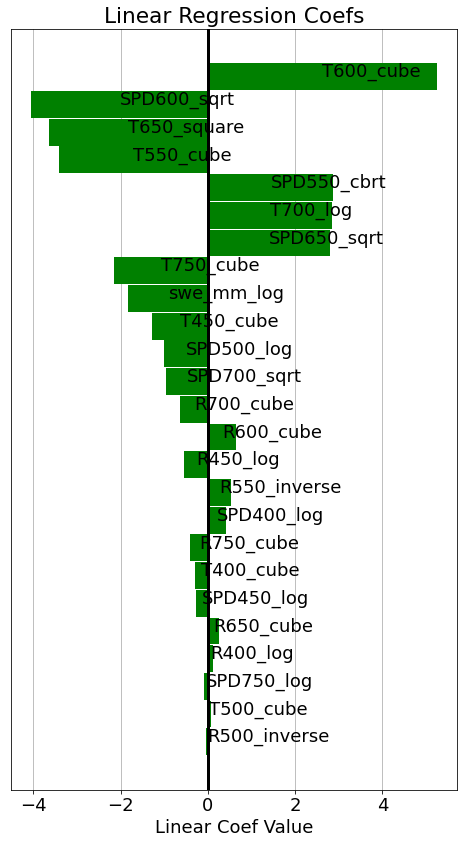

In [84]:
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(1, 1, facecolor='w', figsize=(8, 14))

ranksort = np.argsort(abs(lr.coef_))[::-1]
lr_coefs = lr.coef_[ranksort]
lr_keys = X_train_norm.keys()[ranksort]
mask = lr_coefs != 0

ax.axvline(0, color='k', linewidth=3, zorder=11)
ax.barh(lr_keys[mask], lr_coefs[mask], color='green', zorder=10, height=0.97)

for i, k in enumerate(lr_keys[mask]):
    if lr_coefs[i] != 0:
        ax.text(lr_coefs[i]/2, k, k, zorder=20)

ax.invert_yaxis()
ax.axes.get_yaxis().set_visible(False)
ax.set_title('Linear Regression Coefs')
ax.set_xlabel('Linear Coef Value')
ax.grid(zorder=-1)

0.3285587584982162


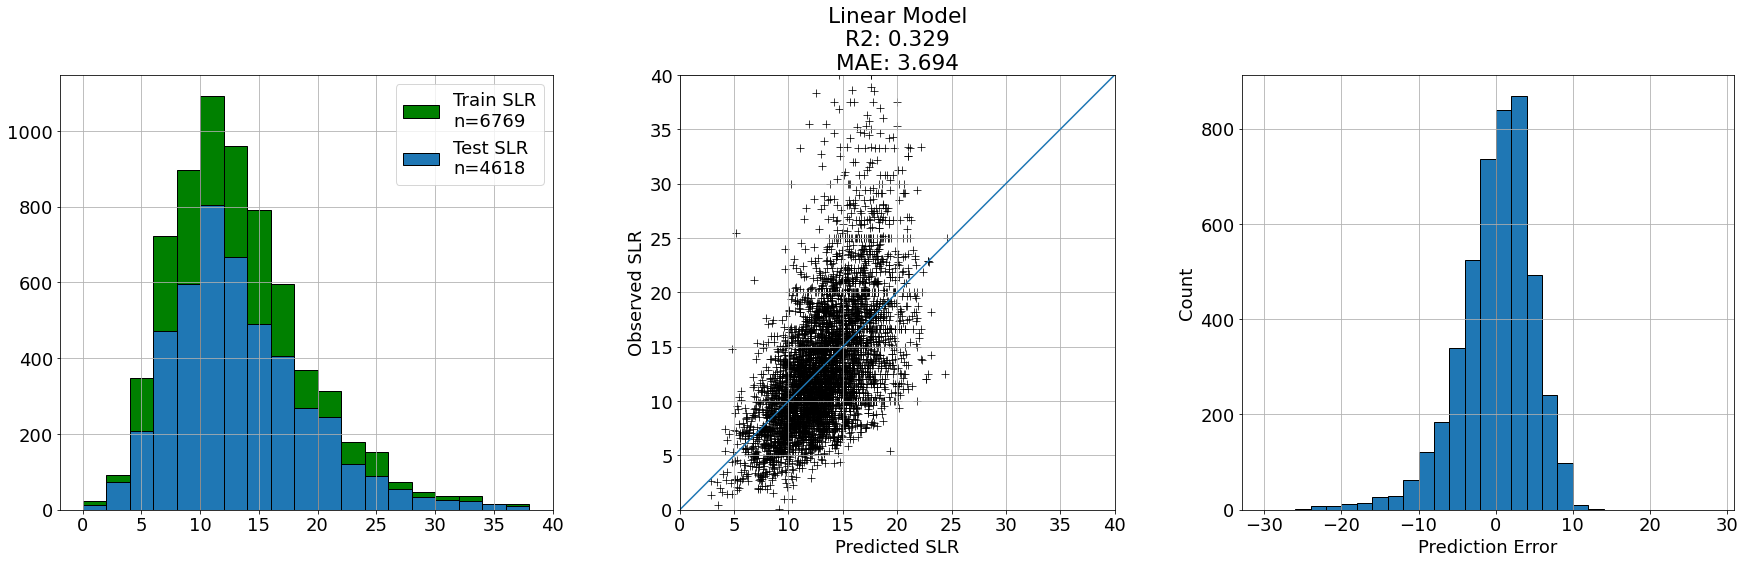

In [85]:
test_predictions = lr.predict(X_test_norm)

_y_train = y_train
_y_test = y_test
_test_predictions = test_predictions

correlation_matrix = np.corrcoef(test_predictions, y_test)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print(r_squared)

lr_mae = np.nanmean(abs(test_predictions - _y_test))

maxslr = test_predictions.max() if test_predictions.max() > _y_test.max() else _y_test.max()
maxslr += 5

fig, axs = plt.subplots(1, 3, figsize=(30, 8), facecolor='w')

ax = axs[0]
maxslr = _y_test.max() if _y_test.max() > _y_train.max() else _y_train.max()

ax.hist(_y_train, bins=np.arange(0, maxslr, 2), color='g', edgecolor='k', alpha=1.0, label='Train SLR\nn=%d'%len(_y_train))
ax.hist(_y_test, bins=np.arange(0, maxslr, 2), color='C0', edgecolor='k', alpha=1.0, label='Test SLR\nn=%d'%len(_y_test))
ax.legend()

ax.set_xticks(np.arange(0, maxslr+1, 5))
ax.set_xticklabels(np.arange(0, maxslr+1, 5).astype(int))
ax.grid()

ax = axs[1]
maxslr = test_predictions.max() if test_predictions.max() > _y_test.max() else _y_test.max()
# maxslr += 5
# maxslr = 50
ax.scatter(test_predictions, _y_test, c='k', s=50, marker='+', linewidth=0.75)
ax.set_ylabel('Observed SLR')
ax.set_xlabel('Predicted SLR')
ax.plot([0, maxslr], [0, maxslr])
ax.set_xlim([0, maxslr])
ax.set_ylim([0, maxslr])
ax.set_aspect('equal')
ax.grid()
axs[1].set_title('Linear Model\nR2: %.3f\nMAE: %.3f'%(r_squared, lr_mae))

ax = axs[2]
error = test_predictions - _y_test
ax.hist(error, bins=np.arange(-30, 30, 2), edgecolor='k')
ax.set_xlabel('Prediction Error')
ax.set_ylabel('Count')
ax.grid()

# fig.suptitle('MultiLayer Perceptron (Simple ANN) [%d Hidden Layer Sizes]'%layer_sizes)

Elastic Train Score: 0.312
Elastic Test Score: 0.326


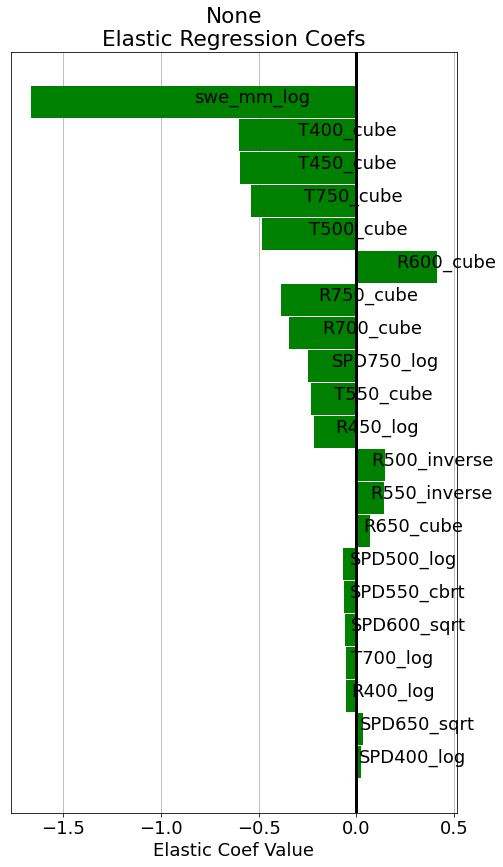

0.32735073520595687


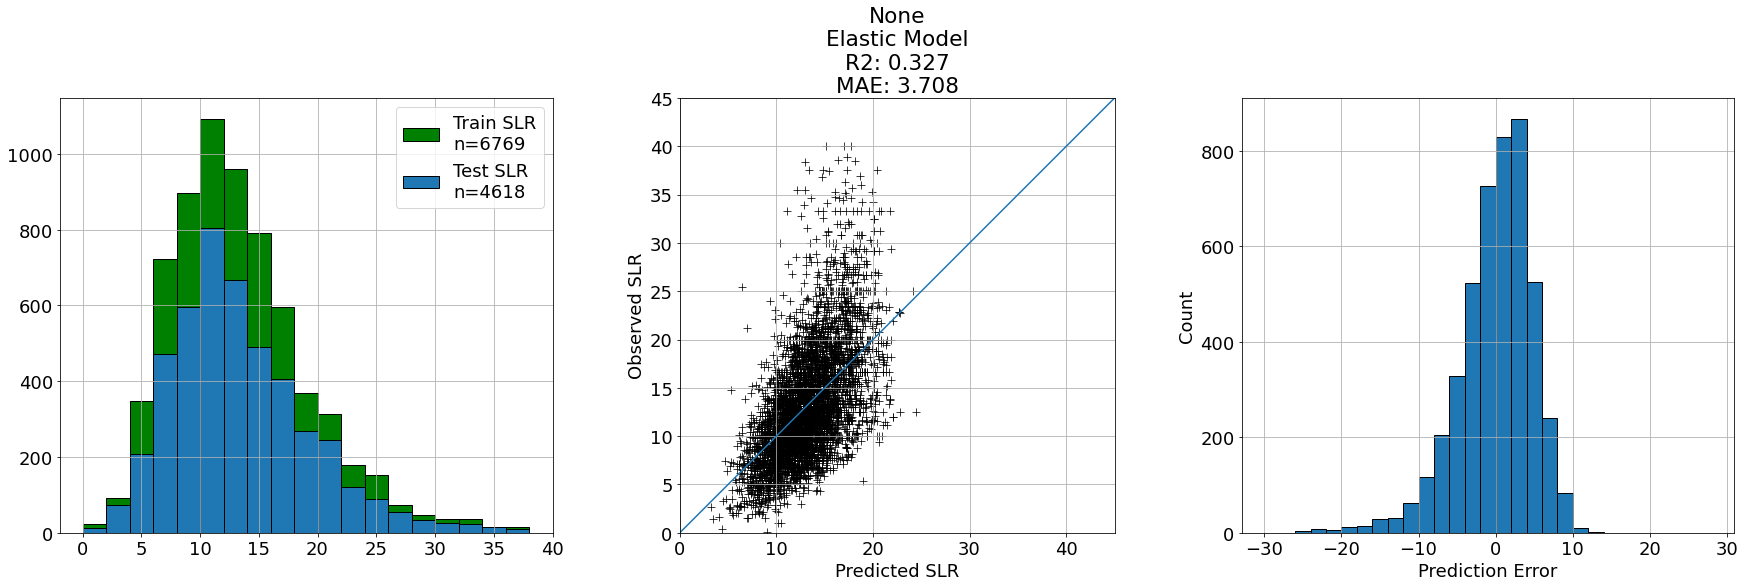

In [86]:
from sklearn.linear_model import ElasticNet

# Grid-search for best parameters? (alpha and l1_ratio)

elastic = ElasticNet(alpha=0.1, l1_ratio=0.1, max_iter=10e5)
elastic.fit(X_train_norm, y_train)

elastic_train_score = elastic.score(X_train_norm, y_train)
elastic_test_score = elastic.score(X_test_norm, y_test)
elastic_coeff_used = np.sum(elastic.coef_ != 0)
    
print('Elastic Train Score: %.3f'%elastic_train_score)
print('Elastic Test Score: %.3f'%elastic_test_score)

fig, ax = plt.subplots(1, 1, facecolor='w', figsize=(8, 14))

ranksort = np.argsort(abs(elastic.coef_))[::-1]
elastic_coefs = elastic.coef_[ranksort]
elastic_keys = X_train_norm.keys()[ranksort]
mask = elastic_coefs != 0

ax.axvline(0, color='k', linewidth=3, zorder=11)
ax.barh(elastic_keys[mask], elastic_coefs[mask], color='green', zorder=10, height=0.97)

for i, k in enumerate(elastic_keys[mask]):
    if elastic_coefs[i] != 0:
        ax.text(elastic_coefs[i]/2, k, k, zorder=20)

ax.invert_yaxis()
ax.axes.get_yaxis().set_visible(False)
ax.set_title('%s\nElastic Regression Coefs'%None)
ax.set_xlabel('Elastic Coef Value')
ax.grid(zorder=-1)
plt.show()

test_predictions = elastic.predict(X_test_norm)
elastic_mae = np.nanmean(abs(test_predictions - y_test))

correlation_matrix = np.corrcoef(test_predictions, y_test)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print(r_squared)

maxslr = test_predictions.max() if test_predictions.max() > y_test.max() else y_test.max()
maxslr += 5

fig, axs = plt.subplots(1, 3, figsize=(30, 8), facecolor='w')

ax = axs[0]
maxslr = y_test.max() if y_test.max() > y_train.max() else y_train.max()

ax.hist(y_train, bins=np.arange(0, maxslr, 2), color='g', edgecolor='k', alpha=1.0, label='Train SLR\nn=%d'%len(y_train))
ax.hist(y_test, bins=np.arange(0, maxslr, 2), color='C0', edgecolor='k', alpha=1.0, label='Test SLR\nn=%d'%len(y_test))
ax.legend()

ax.set_xticks(np.arange(0, maxslr+1, 5))
ax.set_xticklabels(np.arange(0, maxslr+1, 5).astype(int))
ax.grid()

ax = axs[1]
maxslr = test_predictions.max() if test_predictions.max() > y_test.max() else y_test.max()
maxslr += 5
ax.scatter(test_predictions, y_test, c='k', s=50, marker='+', linewidth=0.75)
ax.set_ylabel('Observed SLR')
ax.set_xlabel('Predicted SLR')
ax.plot([0, maxslr], [0, maxslr])
ax.set_xlim([0, maxslr])
ax.set_ylim([0, maxslr])
ax.set_aspect('equal')
ax.grid()
axs[1].set_title('%s\nElastic Model\nR2: %.3f\nMAE: %.3f'%(None, r_squared, elastic_mae))

ax = axs[2]
error = test_predictions - y_test
ax.hist(error, bins=np.arange(-30, 30, 2), edgecolor='k')
ax.set_xlabel('Prediction Error')
ax.set_ylabel('Count')
ax.grid()
plt.show()

MLP Train Score: 0.429
MLP Test Score: 0.379

0.37931715856413956


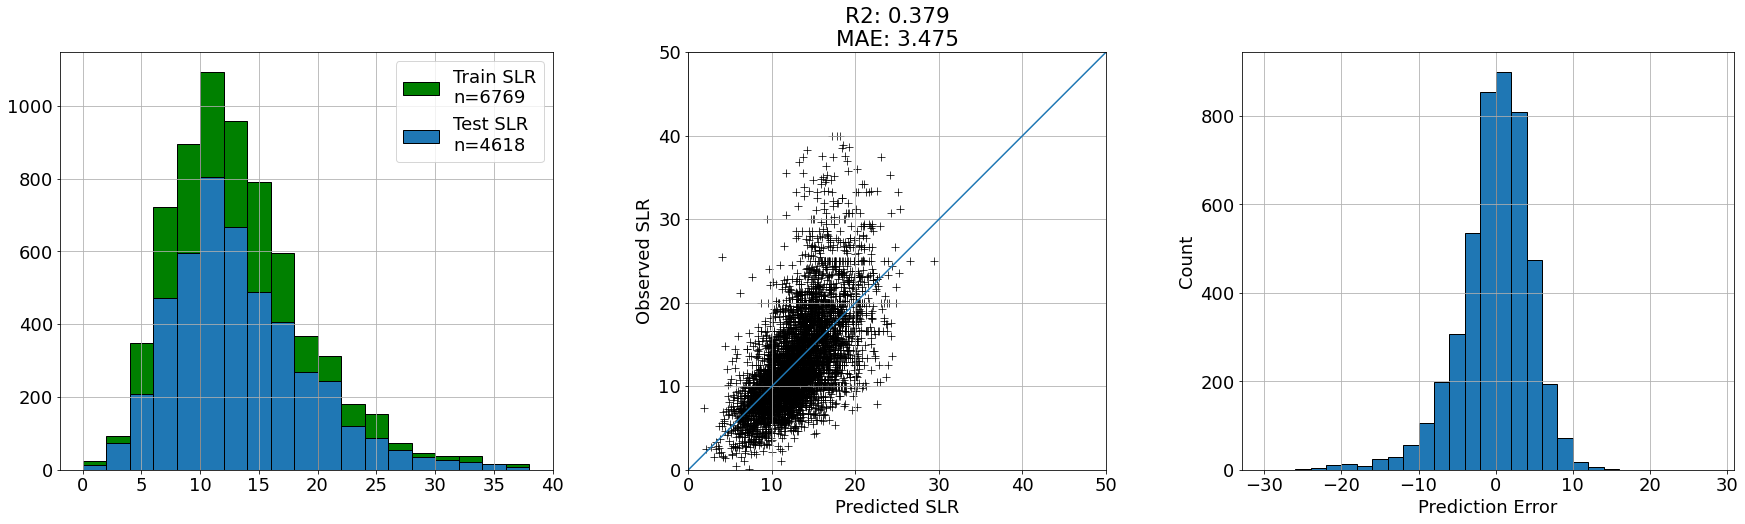

In [87]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(
    hidden_layer_sizes=(100,), 
#     activation='relu', 
#     solver='sgd', 
#     alpha=0.00001, 
#     batch_size='auto', 
#     learning_rate='adaptive', 
#     learning_rate_init=0.0001, 
#     power_t=0.5, 
#     max_iter=50000, 
#     shuffle=True, 
#     random_state=random_state, 
#     tol=0.0001, 
    verbose=False, 
#     warm_start=True, 
#     momentum=0.7, 
#     nesterovs_momentum=True, 
    early_stopping=True, 
#     validation_fraction=0.4, 
#     beta_1=0.5, 
#     beta_2=0.999, 
#     epsilon=1e-8
)

mlp.fit(X_train_norm, y_train)

mlp_train_score = mlp.score(X_train_norm, y_train)
mlp_test_score = mlp.score(X_test_norm, y_test)

print('MLP Train Score: %.3f'%mlp_train_score)
print('MLP Test Score: %.3f'%mlp_test_score)
print()

test_predictions = mlp.predict(X_test_norm)
mlp_mae = np.nanmean(abs(test_predictions - y_test))

correlation_matrix = np.corrcoef(test_predictions, y_test)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print(r_squared)

maxslr = test_predictions.max() if test_predictions.max() > y_test.max() else y_test.max()
maxslr += 5

fig, axs = plt.subplots(1, 3, figsize=(30, 8), facecolor='w')

ax = axs[0]
maxslr = y_test.max() if y_test.max() > y_train.max() else y_train.max()

ax.hist(y_train, bins=np.arange(0, maxslr, 2), color='g', edgecolor='k', alpha=1.0, label='Train SLR\nn=%d'%len(y_train))
ax.hist(y_test, bins=np.arange(0, maxslr, 2), color='C0', edgecolor='k', alpha=1.0, label='Test SLR\nn=%d'%len(y_test))
ax.legend()

ax.set_xticks(np.arange(0, maxslr+1, 5))
ax.set_xticklabels(np.arange(0, maxslr+1, 5).astype(int))
ax.grid()

ax = axs[1]
maxslr = test_predictions.max() if test_predictions.max() > y_test.max() else y_test.max()
maxslr += 5

ax.scatter(test_predictions, y_test, c='k', s=50, marker='+', linewidth=0.75)
maxslr=50

ax.set_ylabel('Observed SLR')
ax.set_xlabel('Predicted SLR')
ax.plot([0, maxslr], [0, maxslr])
ax.set_xlim([0, maxslr])
ax.set_ylim([0, maxslr])
ax.set_aspect('equal')
ax.grid()
axs[1].set_title('R2: %.3f\nMAE: %.3f'%(r_squared, mlp_mae))

ax = axs[2]
error = test_predictions - y_test
ax.hist(error, bins=np.arange(-30, 30, 2), edgecolor='k')
ax.set_xlabel('Prediction Error')
ax.set_ylabel('Count')
ax.grid()

fig.subplots_adjust(top=.85)
# fig.suptitle('%s\nMultiLayer Perceptron (Simple ANN)'%(group_label))
plt.show()

In [88]:
np.save('../gfs/mlp_slr_model', mlp, allow_pickle=True)
np.save('../gfs/elastic_slr_model', elastic, allow_pickle=True)
np.save('../gfs/linear_slr_model', lr, allow_pickle=True)

np.save('../gfs/slr_model_keys', list(X_test_norm.keys()), allow_pickle=True)
np.save('../gfs/slr_model_scaler', scaler, allow_pickle=True)

In [89]:
def MARE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

def SVR_mp(_params):
    
    print('.', end='')
    
    _i, _j, _C, _e = _params
    
    _model = SVR(
                C=_C, #Ridge regularization parameter for (L2)^2 penalty
                epsilon=_e, #Specifies the epsilon-tube within which no penalty is associated in the training loss function
                kernel='rbf', #'linear', 'polynomial', 'rbf'
                degree=3, #pass interger for 'polynomial' kernel, ignored otherwise
                tol=0.001, #stopping tolerance
                shrinking=False, 
                cache_size=200, 
                verbose=False)
    
    _model.fit(X_train_norm, y_train)
    
    test_predictions = _model.predict(X_test_norm).flatten()
    _r2 = _model.score(X_test_norm, y_test) #sklearn.metrics.r2_score(y_test.values.flatten(), test_predictions)
    _mse = sklearn.metrics.mean_squared_error(y_test.values.flatten(), test_predictions)
    _mae = sklearn.metrics.mean_absolute_error(y_test.values.flatten(), test_predictions)
    _mare = MARE(y_test.values.flatten(), test_predictions)
    
    return (_i, _j, _C, _e, _r2, _mae, _mse, _mare, _model)

In [90]:
import multiprocessing as mp
from sklearn.svm import SVR
import sklearn

# Best test
crange = np.arange(1, 50, 1)
erange = np.arange(1.0, 4.1, .25)

# crange = np.arange(1, 25, 1)
# erange = np.arange(0.1, 3.1, .1)

params = {}
params['r2'] = np.zeros((len(crange), len(erange)))
params['mae'] = np.zeros((len(crange), len(erange)))
params['mse'] = np.zeros((len(crange), len(erange)))
params['mare'] = np.zeros((len(crange), len(erange)))
params['model'] = np.empty((len(crange), len(erange)), dtype='object')
params['epsilon'] = np.zeros((len(crange), len(erange)))
params['C'] = np.zeros((len(crange), len(erange)))

mp_params = np.array([[(i, j, C, e) for j, e in enumerate(erange)] 
                      for i, C in enumerate(crange)]).reshape(-1, 4)

print('Iterations to attempt: %d'%len(mp_params))

Iterations to attempt: 637


In [91]:
# Paralellize here
# mp_returns = [SVR_mp(_param) for _param in mp_params[:10]]

with mp.get_context('fork').Pool(64) as p:
    mp_returns = p.map(SVR_mp, mp_params, chunksize=1)
    p.close()
    p.join()

for item in mp_returns:
    
    i, j, C, e, r2, mae, mse, mare, model = item
    i, j = int(i), int(j)
        
    params['r2'][i, j] = r2
    params['mse'][i, j] = mse
    params['mae'][i, j] = mae
    params['mare'][i, j] = mare
    params['model'][i, j] = model
    params['epsilon'][i, j] = e
    params['C'][i, j] = C

.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

MARE  0.3350654515148817


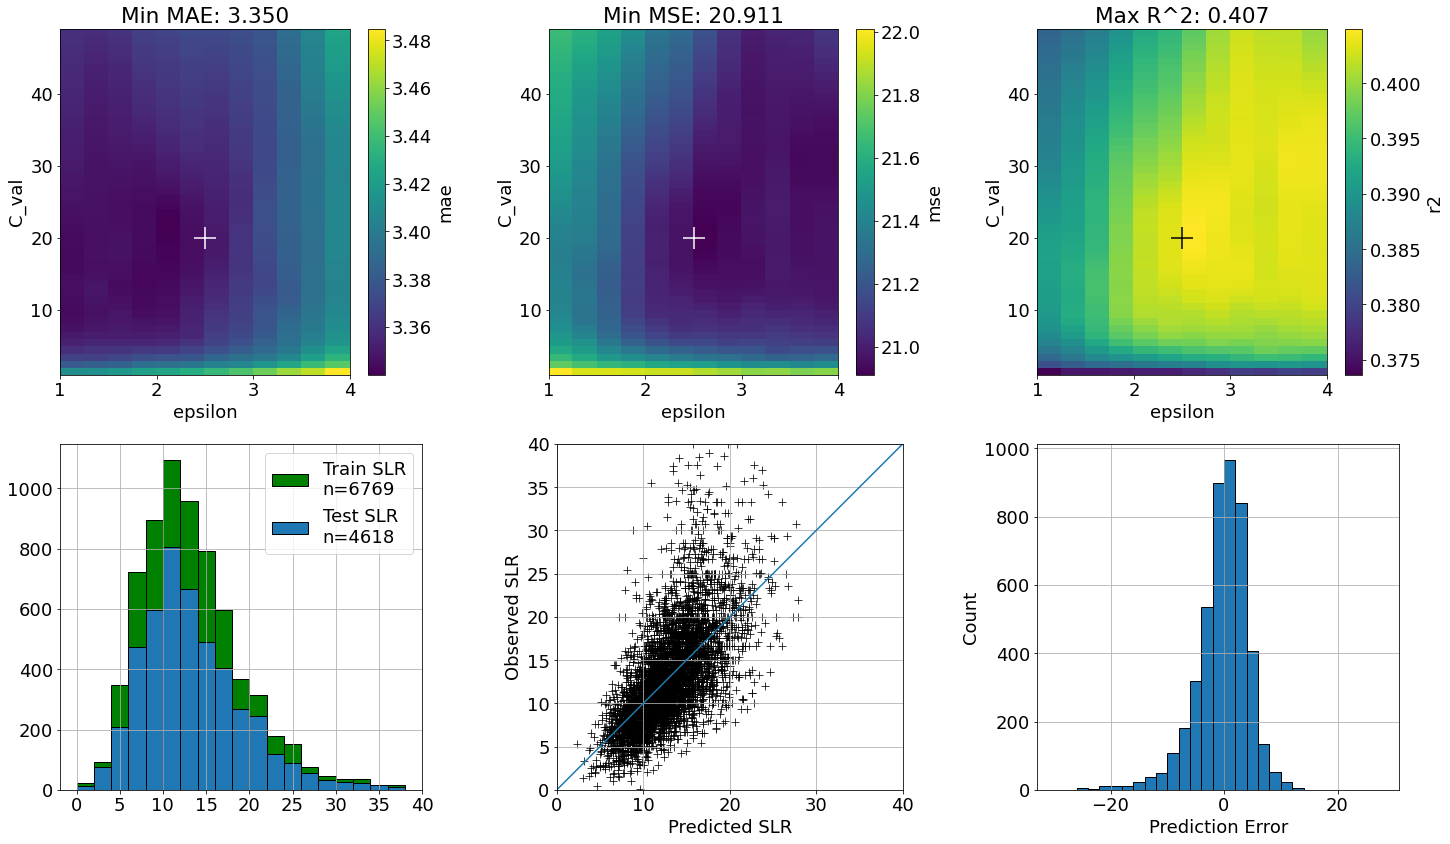

In [92]:
min_on, indexer, _ = 'R2', np.where(params['r2'] == params['r2'].max()), params['r2'].max()
min_on, indexer, _ = 'MAE', np.where(params['mae'] == params['mae'].min()), params['mae'].min()
min_on, indexer, _ = 'MSE', np.where(params['mse'] == params['mse'].min()), params['mse'].min()
min_on, indexer, _ = 'MARE', np.where(params['mare'] == params['mare'].min()), params['mare'].min()

for min_on in ['mse']:
    
    if min_on in ['mse', 'mae', 'mare']:
        min_max = 'Minimized'
        indexer = np.where(params[min_on] == params[min_on].min())
    elif min_on in ['r2']:
        min_max = 'Maximized'
        indexer = np.where(params[min_on] == params[min_on].max())

    r, c = indexer
    r, c = r[0], c[0]
    r, c, _

    model = params['model'][r, c]
    test_predictions = model.predict(X_test_norm)
    
    correlation_matrix = np.corrcoef(test_predictions, y_test)
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    
    y_true = y_test
    y_pred = test_predictions
    print('MARE ', MARE(y_true, y_pred))

    fig, axs = plt.subplots(2, 3, facecolor='w', figsize=(24, 14))
    axs = axs.flatten()

    ax = axs[0]
    cbar = ax.pcolormesh(erange, crange, params['mae'])
    plt.colorbar(cbar, label='mae', ax=ax)
    ax.set_title('Min MAE: %.3f'%params['mae'][r, c])
    ax.scatter(params['epsilon'][r, c], params['C'][r, c], s=500, c='w', marker='+')

    ax = axs[1]
    cbar = ax.pcolormesh(erange, crange, params['mse'])
    plt.colorbar(cbar, label='mse', ax=ax)
    ax.set_title('Min MSE: %.3f'%params['mse'][r, c])
    ax.scatter(params['epsilon'][r, c], params['C'][r, c], s=500, c='w', marker='+')

    ax = axs[2]
    cbar = ax.pcolormesh(erange, crange, params['r2'])
    plt.colorbar(cbar, label='r2', ax=ax)
    ax.set_title('Max R^2: %.3f'%r_squared)#params['r2'][r, c])
    ax.scatter(params['epsilon'][r, c], params['C'][r, c], s=500, c='k', marker='+')

    for ax in axs[:3]:
        ax.set_xlabel('epsilon')
        ax.set_ylabel('C_val')
        ax.set_ylim([crange.min(), crange.max()])
        ax.set_xlim([erange.min(), erange.max()])

    ax = axs[3]
    maxslr = y_test.max() if y_test.max() > y_train.max() else y_train.max()

    ax.hist(y_train, bins=np.arange(0, maxslr, 2), color='g', edgecolor='k', alpha=1.0, label='Train SLR\nn=%d'%len(y_train))
    ax.hist(y_test, bins=np.arange(0, maxslr, 2), color='C0', edgecolor='k', alpha=1.0, label='Test SLR\nn=%d'%len(y_test))
    ax.legend()

    ax.set_xticks(np.arange(0, maxslr+1, 5))
    ax.set_xticklabels(np.arange(0, maxslr+1, 5).astype(int))
    ax.grid()

    ax = axs[4]
    maxslr = test_predictions.max() if test_predictions.max() > y_test.max() else y_test.max()
    #     maxslr += 5
    ax.scatter(test_predictions, y_test, c='k', s=50, marker='+', linewidth=0.75)
    ax.set_ylabel('Observed SLR')
    ax.set_xlabel('Predicted SLR')
    ax.plot([0, maxslr], [0, maxslr])
    ax.set_xlim([0, maxslr])
    ax.set_ylim([0, maxslr])
    ax.set_aspect('equal')
    ax.grid()

    ax = axs[5]
    error = test_predictions - y_test
    ax.hist(error, bins=np.arange(-30, 30, 2), edgecolor='k')
    ax.set_xlabel('Prediction Error')
    ax.set_ylabel('Count')
    ax.grid()

#     plt.suptitle('Support Vector Regression Model\n%s\n%s on: %s\nepsilon %.3f\nc_val: %.3f'%(site_list, min_max, min_on.upper(), params['epsilon'][r, c], params['C'][r, c]))
    fig.subplots_adjust(wspace=0.35)
    plt.show()

In [93]:
np.save('../gfs/SVR_slr_model', model, allow_pickle=True)

In [94]:
list(X_test_norm.keys())

['T500_cube',
 'T450_cube',
 'T550_cube',
 'swe_mm_log',
 'T400_cube',
 'T600_cube',
 'T650_square',
 'T700_log',
 'T750_cube',
 'SPD600_sqrt',
 'SPD650_sqrt',
 'SPD550_cbrt',
 'SPD700_sqrt',
 'SPD500_log',
 'SPD750_log',
 'SPD450_log',
 'SPD400_log',
 'R400_log',
 'R750_cube',
 'R450_log',
 'R700_cube',
 'R650_cube',
 'R500_inverse',
 'R600_cube',
 'R550_inverse']